# H2 visa application data analysis

* Description
* Dataset
* Goal 
* Imports
* Data exploration
* Initial visualizations
* Data cleaning
* Visualization after the cleaning
* Goal - How has the number of approved applications changed over time?
* Goal - How have the number of approved workers changed over time?
* Goal - Which locations and types of businesses request the most visas and how has this changed over time?
* Goal - Which positions are the most frequently requested for these visas? 

(rest of the table of contents, to be appended in the end)

## Description

H2 visa applications are requests by companies to hire foreign workers for nonagricultural jobs within the United States. The U.S. Department of Labor releases this data as Excel (.XLS) files and BuzzFeed News has been tracking and hosting these datasets on Github. The dataset we’ll be working with represents H2 applications from October 1, 2010 to March 31, 2016.

This is a weekly challenge done as a part of Data Science coursework on www.dataquest.io

## Dataset

Raw data from US Dept of Labor (XLS files):

https://github.com/BuzzFeedNews/H2certificationdata/tree/master/data/raw


Cleaned up, aggregated CSV file 

https://github.com/BuzzFeedNews/H2certificationdata/blob/master/data/processed/H2certificationdecisions.csv


Read more about H2 visas and how they work:

https://www.uscis.gov/workingunitedstates/temporaryworkers/h2btemporarynonagriculturalworkers

#### VARIABLES used in the data - 

 **case_no** :  The OFLC-assigned case number.

 **visa_type** : "H-2A" or "H-2B".
    
 **fy** : The fiscal year of the most recent OFLC decision/progress on the case.
    
 **last_event_date** : The date of the most recent OFLC decision/progress on the case.
    
 **case_status** : The status of the case; typically a variation on "CERTIFIED", "DENIED", "WITHDRAWN", et cetera.

 **n_requested** : The number of workers/visas requested.
    
 **n_certified**: The number of workers/visas certified.

 **is_certified**: True/False; a standardization of the case_status field.

 **certification_begin_date / certification_begin_date** : "Actual date granted to an employer indicating when the need for the foreign workers to perform agricultural services or labor is expected to [begin / end]." Unavailable for H-2B data prior to FY2007.

 **job_title** : The job title listed by the employer.

 **employer_name** : The name of the employer applying for certification; converted to all-caps.
    
 **employer_state** : The state the employer listed.

 **employer_city** : The city the employer listed.

 **employer_address_1** : The first line of the address the employer listed.

 **employer_address_2** : The second line of the address the employer listed.
    
 **employer_postal_code** : The postal code the employer listed.
    
 **agent_name** : The name of the agent or attorney filing the application for the employer. Some years of data include multiple columns related to visa agents; the standardized field combines these fields, separating them by a :.

 **organization_flag** : Various types of organizations — including sole employers and joint employers — can apply for visa certifications. This field tracks OFLC's categorizations. Only available for H-2A decisions.
    
 **is_duplicate: True/False/null** : This derived value will be True — indicating that this row corresponds a sub-application of a joint employer's "master application" — if (a) visa_type is "H-2A", (b) the organization_flag is blank, and (c) comes from fiscal year 2008 or later. H-2A data from FY 2006 and FY 2007 do not contain a organization_flag field. For these records, and H-2B records, is_duplicate will be null.

## Goal

To answer these questions

1. How has the number of approved applications changed over time?

2. How have the number of approved workers changed over time?

3. Which locations and types of businesses request the most visas and how has this changed over time?

4. Which positions are the most frequently requested for these visas? 

Bonus
* Look for new dataset(s) to deepen your analysis. Here are some ideas:
* What datasets can help you further segment the job_title column?
* What datasets, if any, can help you further segment the employer_name column?

After that -

1) How has the number of applications changed over time

2) How has the number of people approved changed over time

3) Map of states in the beginning, map of states in the end

4) Work on job titles

## Imports 

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas_profiling

## Data Exploration

Reading the data

In [5]:
visa = pd.read_csv("H-2-certification-decisions.csv",low_memory=False)
visa.head()

,case_no,visa_type,fy,last_event_date,case_status,n_requested,n_certified,is_certified,certification_begin_date,certification_end_date,...,employer_state,employer_city,employer_address_1,employer_address_2,employer_postal_code,worksite_state,worksite_city,agent_name,organization_flag,is_duplicate
0,9455254,H-2B,2000,1999-10-01,"DENIED, TEMPORARY",1,0,False,NaN,NaN,...,CA,LOS ANGELES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8222219,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",2,2,True,NaN,NaN,...,CO,BEAVER CREEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8222168,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",2,2,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8222169,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",5,5,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,8222170,H-2B,2000,1999-10-04,"CERTIFIED, TEMPORARY",40,40,True,NaN,NaN,...,CO,MT. CRESTED BUTTE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Checking the datatypes of all the columns

In [6]:
visa.dtypes

case_no                      object
visa_type                    object
fy                            int64
last_event_date              object
case_status                  object
n_requested                 float64
n_certified                   int64
is_certified                   bool
certification_begin_date     object
certification_end_date       object
job_title                    object
employer_name                object
employer_state               object
employer_city                object
employer_address_1           object
employer_address_2           object
employer_postal_code         object
worksite_state               object
worksite_city                object
agent_name                   object
organization_flag            object
is_duplicate                 object
dtype: object

Checking each column to see how much percentage of each column has null values. This is to determine which columns would be more significant for analysis and which columns are to be left out

In [7]:
ind = []
val = []
for col in visa.columns:
    ind.append(col + " % null : ")
    try: 
        value = (pd.isnull(visa[col]).value_counts()[True]/visa.shape[0])*100
    except:
        value = 0
    val.append(round(value,2))
    
null_table = pd.Series(val,index=ind)
null_table.sort_values()

case_no % null :                       0.00
visa_type % null :                     0.00
fy % null :                            0.00
case_status % null :                   0.00
n_certified % null :                   0.00
is_certified % null :                  0.00
employer_name % null :                 0.01
employer_city % null :                 0.04
employer_state % null :                0.06
job_title % null :                     0.23
last_event_date % null :               3.50
employer_address_1 % null :           20.62
employer_postal_code % null :         20.77
agent_name % null :                   26.84
certification_begin_date % null :     27.12
certification_end_date % null :       27.12
worksite_state % null :               29.59
n_requested % null :                  33.61
worksite_city % null :                61.54
is_duplicate % null :                 64.68
organization_flag % null :            77.89
employer_address_2 % null :           89.87
dtype: float64

Checking the summary statistics of columns with integer values

In [9]:
visa.describe()

,fy,n_requested,n_certified,is_certified
count,213155.000000,141512.000000,213155.000000,213155
mean,2008.956998,18.916516,16.053646,0.873585
std,4.375681,42.546266,39.135363,0.332317
min,2000.000000,0.000000,0.000000,False
25%,2006.000000,3.000000,2.000000,1
50%,2009.000000,8.000000,6.000000,1
75%,2013.000000,19.000000,15.000000,1
max,2016.000000,1866.000000,1866.000000,True


#### Case status classification

Case status has a number of repeated statuses which are one and the same.
Creating a map in order to classify them more sensibly

In [11]:
status_map = {"CERTIFIED - FULL" : "CERTIFIED",
              "CERTIFIED" : "CERTIFIED",
              "DETERMINATION ISSUED - CERTIFICATION": "CERTIFIED",
              "CERTIFICATION":"CERTIFIED",
              "PARTIAL CERTIFIED" : "PARTIAL CERTIFIED",
              "DENIED" : "DENIED",
              "WITHDRAWN" : "WITHDRAWN",
              "PARTIAL CERTIFICATION" : "PARTIAL CERTIFIED",
              "CERTIFIED - PARTIAL":"PARTIAL CERTIFIED",
              "DETERMINATION ISSUED - CERTIFICATION EXPIRED" : "CERTIFICATION EXPIRED",
              "DETERMINATION ISSUED - DENIED" : "DENIED",
              "CERTIFICATION EXPIRED" : "CERTIFICATION EXPIRED",
              "DETERMINATION ISSUED - WITHDRAWN" : "WITHDRAWN",
              "DETERMINATION ISSUED - PARTIAL CERTIFICATION": "PARTIAL CERTIFIED",
              "PARTIAL CERTIFICATION EXPIRED" : "PARTIAL CERTIFICATION EXPIRED",
              "FINAL REVIEW" : "FINAL REVIEW "
}

visa["case_status"] = visa["case_status"].map(status_map)

Now the data much more organized and condensed for better analysis

In [13]:
visa["case_status"].value_counts()

CERTIFIED                        135887
DENIED                            14050
PARTIAL CERTIFIED                 14031
WITHDRAWN                          3535
CERTIFICATION EXPIRED              1309
PARTIAL CERTIFICATION EXPIRED        84
FINAL REVIEW                          3
Name: case_status, dtype: int64

After the initial data exploration, we can plot of a few graphs to better understand the data at hand

Please note : This is WITHOUT cleaning the data 

## Initial Visualizations

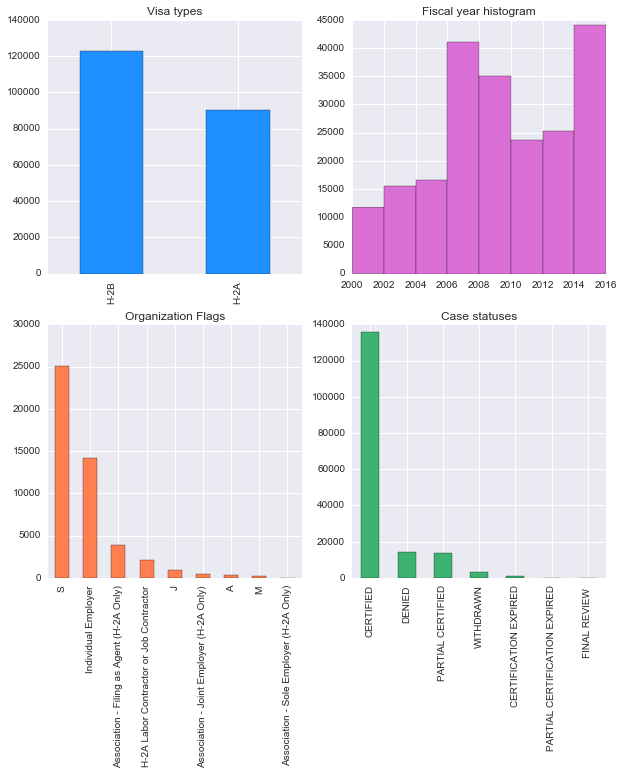

In [14]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
visa["visa_type"].value_counts().plot(kind='bar',title="Visa types",color='dodgerblue')

ax2 = fig.add_subplot(2,2,2)
visa["fy"].hist(color='orchid',bins=8)
plt.title("Fiscal year histogram")

ax3 = fig.add_subplot(2,2,3)
visa["organization_flag"].value_counts().plot(kind='bar',title="Organization Flags",color='coral')

ax4 = fig.add_subplot(2,2,4)
visa["case_status"].value_counts().plot(kind='bar',title="Case statuses",color='mediumseagreen')

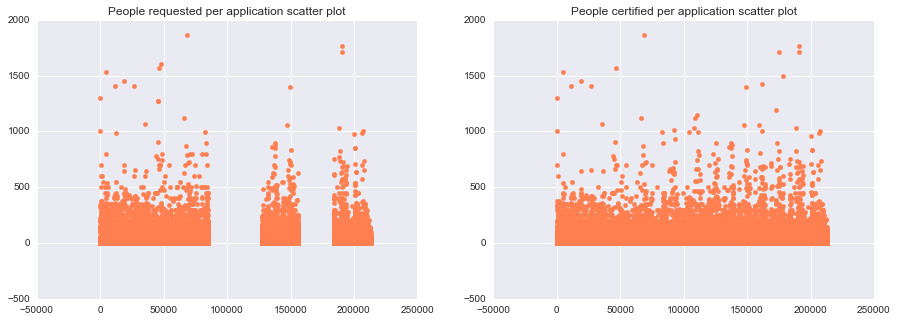

In [15]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(1,2,1)
plt.scatter(x=visa["n_requested"].index,y=visa["n_requested"].values,color='coral')
plt.title("People requested per application scatter plot")

ax2 = fig.add_subplot(1,2,2)
plt.scatter(x=visa["n_certified"].index,y=visa["n_certified"].values,color='coral')
plt.title("People certified per application scatter plot")

We can see from above that two significant chunks of data are missing from the 'People requested per application' scatter plot.

But it seems to have a similar pattern to the 'People certified per application' scatterplot 

## Data cleaning

In [16]:
# removing duplicates

# First removing duplicate rows using drop_duplicates function
visa_uni = visa.drop_duplicates()
print("Number of duplicate rows removed")
print(visa.duplicated().value_counts()[True])

Number of duplicate rows removed
152


In [17]:
# removing rows where the column "is_duplicate" is marked as True
# The is_duplicate column value will be True — indicating that this row corresponds a sub-application of a joint employer's 
# "master application"

print("Number of rows being removing")
print(visa_uni[visa_uni["is_duplicate"] == True].shape[0])

visa_uni = visa_uni[visa_uni["is_duplicate"] != True]

Number of rows being removing
28025


## Visualizations after the cleaning

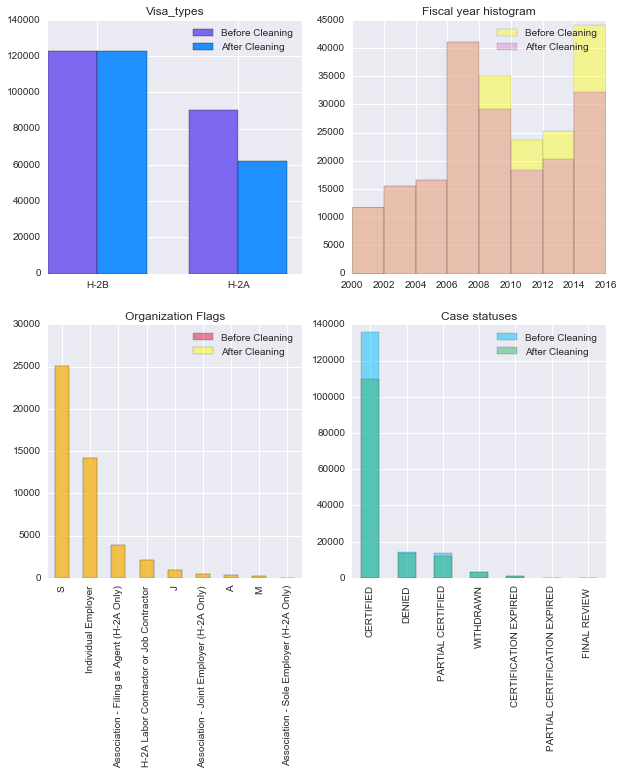

In [18]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
locs_1 = np.arange(2)
off_1 = locs_1 + 0.35
ax1.bar(left=locs_1,height=visa["visa_type"].value_counts().tolist(),color='mediumslateblue',width=0.35)
ax1.bar(left=off_1,height=visa_uni["visa_type"].value_counts().tolist(),color='dodgerblue',width=0.35)
ax1.set_xticklabels(visa["visa_type"].value_counts().index.tolist())
ax1.set_xticks(off_1)
plt.legend(("Before Cleaning","After Cleaning"))
plt.title("Visa_types")
#visa["visa_type"].value_counts().plot(kind='bar',title="Visa types",color='mediumslateblue',alpha=0.5)
#visa_uni["visa_type"].value_counts().plot(kind='bar',title="Visa types",color='dodgerblue',alpha=0.5)


ax2 = fig.add_subplot(2,2,2)
visa["fy"].hist(color='yellow',bins=8,alpha=0.4)
visa_uni["fy"].hist(color='orchid',bins=8,alpha=0.4)
plt.title("Fiscal year histogram")
plt.legend(("Before Cleaning","After Cleaning"))

ax3 = fig.add_subplot(2,2,3)
visa["organization_flag"].value_counts().plot(kind='bar',title="Organization Flags",color='crimson',alpha=0.5)
visa_uni["organization_flag"].value_counts().plot(kind='bar',title="Organization Flags",color='yellow',alpha=0.5)
plt.legend(("Before Cleaning","After Cleaning"))

ax4 = fig.add_subplot(2,2,4)
visa["case_status"].value_counts().plot(kind='bar',title="Case statuses",color='deepskyblue',alpha=0.5)
visa_uni["case_status"].value_counts().plot(kind='bar',title="Case statuses",color='mediumseagreen',alpha=0.5)
plt.legend(("Before Cleaning","After Cleaning"))

As we can see, there are a few changes in the graphs after the data has been cleaned

There are NO changes in the Organization Flags plot

## Goal - How has the number of approved applications changed over time?

In [19]:
visa_uni.loc[:,"case_count"] = 1
year_status = visa_uni.pivot_table(values="case_count",index="case_status",columns="fy",aggfunc=np.sum)
year_status

fy,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
case_status,,,,,,,,,,,,,,,,,
CERTIFICATION EXPIRED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1193,NaN,66
CERTIFIED,NaN,1,NaN,NaN,NaN,NaN,15684,17468,13964,8714,6360,6842,7500,8627,8987,11495,4282
DENIED,NaN,NaN,NaN,NaN,NaN,NaN,2255,3963,1090,1389,1062,853,742,678,660,825,411
FINAL REVIEW,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PARTIAL CERTIFICATION EXPIRED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73,NaN,11
PARTIAL CERTIFIED,NaN,NaN,NaN,NaN,NaN,NaN,313,820,1536,2012,1445,1549,1341,1069,827,811,532
WITHDRAWN,14,40,37,46,44,34,NaN,NaN,233,236,99,106,87,308,416,953,634


As we can see above, a lot of values are missing/unavailable/zero, especially for years 2000-2007

So we will now plot certified applications from 2006 on

In [20]:
print(year_status.index)
print(year_status.columns)

Index([u'CERTIFICATION EXPIRED', u'CERTIFIED', u'DENIED', u'FINAL REVIEW ',
       u'PARTIAL CERTIFICATION EXPIRED', u'PARTIAL CERTIFIED', u'WITHDRAWN'],
      dtype='object', name=u'case_status')
Int64Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
            2011, 2012, 2013, 2014, 2015, 2016],
           dtype='int64', name=u'fy')


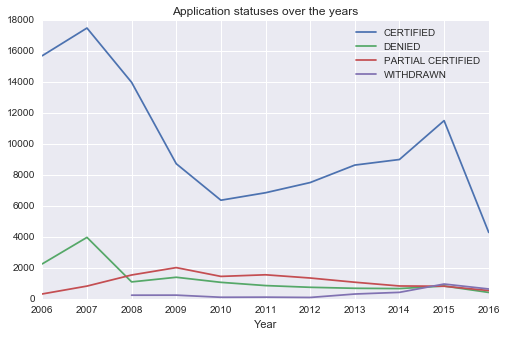

In [21]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks(year_status.columns)
ax.set_xlabel("Year")
ax.plot(year_status.loc['CERTIFIED',2006:])
ax.plot(year_status.loc['DENIED',2006:])
ax.plot(year_status.loc['PARTIAL CERTIFIED',2006:])
ax.plot(year_status.loc['WITHDRAWN',2006:])
plt.legend()
plt.title("Application statuses over the years")


Clearly the number of certified applications over the years has shown a decreasing trend in general

The number of denied applications seem to be more of less the same over the years, which seems to the case with partial certified and withdrawn applications as well

Withdrawn applications seem to have a slight rise in 2016